## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import tensorflow
import keras

import sklearn
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
from platform import python_version

print('python:', python_version())
print('tensowflow:', tensorflow.__version__)
print('keras: ', keras.__version__)

python: 3.7.6
tensowflow: 2.1.0
keras:  2.3.1


In [3]:
#Hyper parameters
batch_size = 200

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
42248,00010869_000.png,Nodule,0,10869,54,M,PA,2992,2991,0.143,0.143,NaN,/data/images_005/images/00010869_000.png
11722,00003064_007.png,Effusion,7,3064,35,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003064_007.png
43748,00011269_005.png,Consolidation,5,11269,41,M,PA,2992,2991,0.143,0.143,NaN,/data/images_005/images/00011269_005.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
90130,00022416_001.png,Atelectasis|Effusion|Infiltration,1,22416,51,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
110965,00030271_000.png,Nodule,0,30271,55,M,PA,2020,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29344,00007632_009.png,No Finding,9,7632,45,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].map(lambda finding: 'True' if 'Pneumonia' in finding else 'False')
all_xray_df.sample(20)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
19437,00005156_000.png,No Finding,0,5156,29,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
22018,00005832_017.png,Atelectasis,17,5832,45,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
105932,00028518_001.png,No Finding,1,28518,48,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
61028,00015058_001.png,No Finding,1,15058,71,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
43439,00011208_001.png,Cardiomegaly,1,11208,75,M,PA,2992,2985,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
17799,00004808_038.png,No Finding,38,4808,35,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
73553,00018091_019.png,Infiltration,19,18091,41,M,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
98242,00025953_000.png,No Finding,0,25953,63,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
82951,00020398_013.png,Atelectasis|Effusion|Infiltration,13,20398,21,F,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3876,00001064_000.png,Fibrosis,0,1064,66,F,PA,2992,2991,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Create your training and testing data:

In [7]:
# I am going to split into 80 and 20

train_df, valid_df = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
IMG_SIZE = (224, 224)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
# so far I will use the standard keras generator
my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

my_idg_no_augmentation = ImageDataGenerator(rescale=1. / 255.0)

train_gen = my_idg.flow_from_dataframe(  dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

val_gen = my_idg_no_augmentation.flow_from_dataframe(dataframe=valid_df, 
                                  directory=None, 
                                  x_col = 'path',
                                  y_col = 'pneumonia_class',
                                  class_mode = 'binary',
                                  target_size = IMG_SIZE, 
                                  batch_size = batch_size
                                  )

Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
print(valY)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


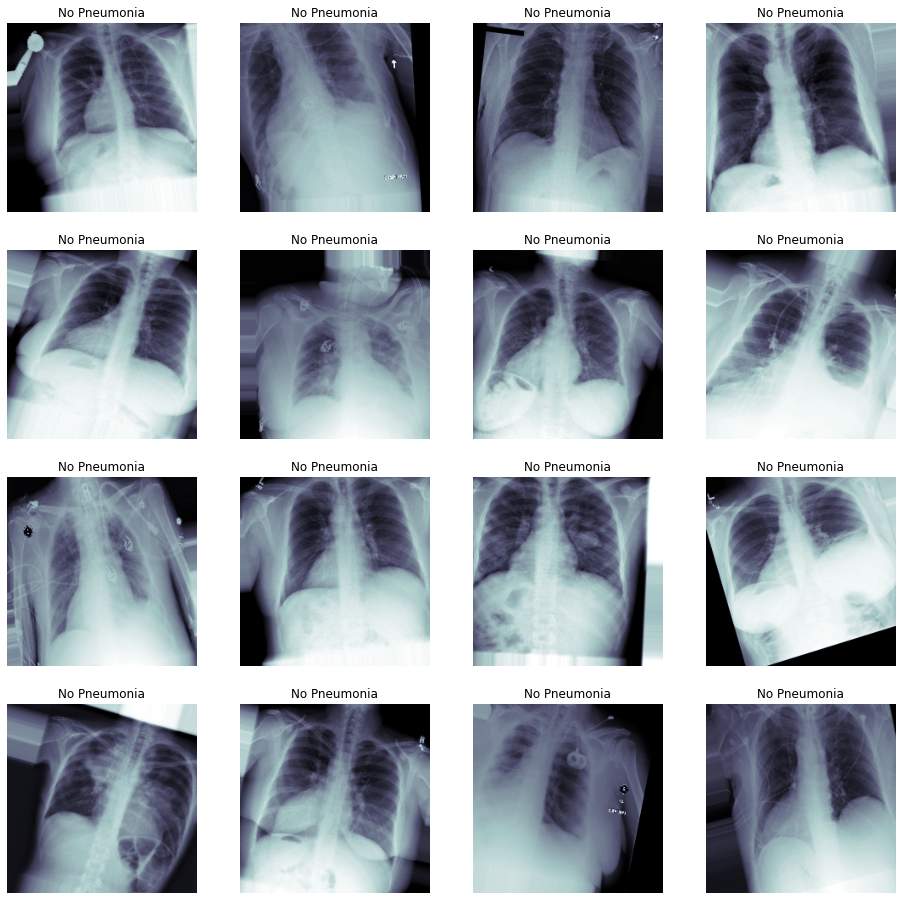

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

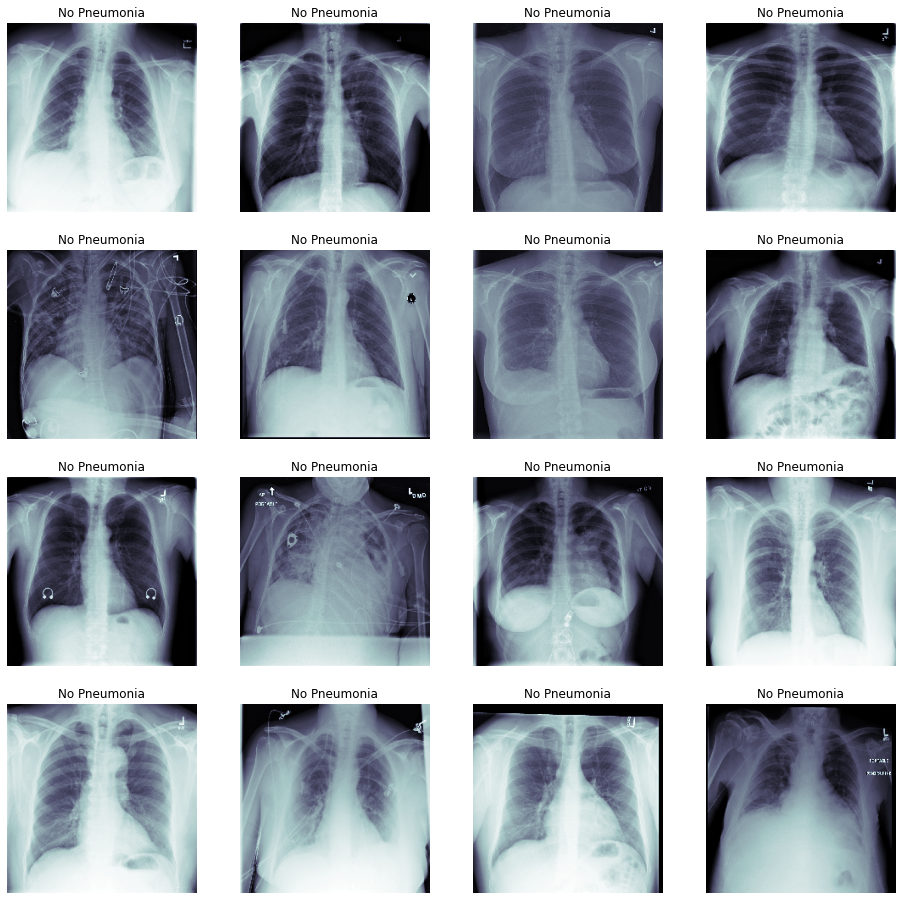

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
model = VGG16(include_top = True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [13]:
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
    
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [14]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [15]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [16]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
## Just run a single epoch to see how it does:
#new_model.fit_generator(train_gen, 
#                                  validation_data = (valX, valY), 
#                                  epochs = 1)

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping( monitor= 'val_binary_accuracy', 
                       mode= 'max', 
                       patience=2)

callbacks_list = [checkpoint, early]

### Start training! 

In [91]:
epochs = 10

In [92]:
history = new_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = epochs, 
                           callbacks = callbacks_list)

Epoch 1/10
449/449 [==============================] - 2432s 5s/step - loss: 0.0703 - binary_accuracy: 0.9872 - val_loss: 0.1185 - val_binary_accuracy: 0.9750

Epoch 00001: val_binary_accuracy improved from -inf to 0.97500, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
449/449 [==============================] - 2481s 6s/step - loss: 0.0696 - binary_accuracy: 0.9872 - val_loss: 0.1204 - val_binary_accuracy: 0.9750

Epoch 00002: val_binary_accuracy did not improve from 0.97500
Epoch 3/10
449/449 [==============================] - 2448s 5s/step - loss: 0.0690 - binary_accuracy: 0.9872 - val_loss: 0.1140 - val_binary_accuracy: 0.9750

Epoch 00003: val_binary_accuracy did not improve from 0.97500


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [19]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

print(pred_Y)

200/200 [==============================] - 9s 44ms/step
[[0.05662267]
 [0.06409982]
 [0.0403135 ]
 [0.06392155]
 [0.06519119]
 [0.08781008]
 [0.02890697]
 [0.04989361]
 [0.09986915]
 [0.03746632]
 [0.0394791 ]
 [0.04736526]
 [0.05020874]
 [0.05487666]
 [0.07390073]
 [0.07638519]
 [0.08096603]
 [0.06324358]
 [0.04193002]
 [0.05373379]
 [0.02832518]
 [0.05808625]
 [0.07010819]
 [0.05733436]
 [0.05662953]
 [0.03913796]
 [0.04223075]
 [0.05726623]
 [0.01373968]
 [0.03429035]
 [0.01706007]
 [0.03325116]
 [0.07836769]
 [0.01106727]
 [0.0395695 ]
 [0.0789491 ]
 [0.02029413]
 [0.06207517]
 [0.06787931]
 [0.03135284]
 [0.02693992]
 [0.02926447]
 [0.0489449 ]
 [0.0576913 ]
 [0.05004146]
 [0.05354346]
 [0.04007574]
 [0.10194316]
 [0.04741672]
 [0.05568708]
 [0.08518921]
 [0.06993561]
 [0.09183263]
 [0.02994001]
 [0.06837999]
 [0.03101258]
 [0.03877936]
 [0.02291168]
 [0.03805038]
 [0.06221887]
 [0.02316169]
 [0.02107199]
 [0.04371801]
 [0.02857548]
 [0.06256471]
 [0.08359928]
 [0.08123047]
 [0.03

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve
#y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valY, pred_Y)
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

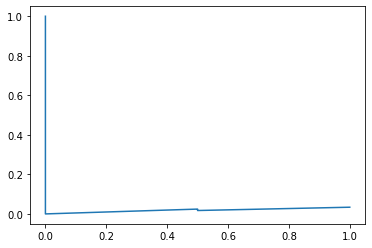

In [21]:
plt.plot(recall, precision)
plt.show()

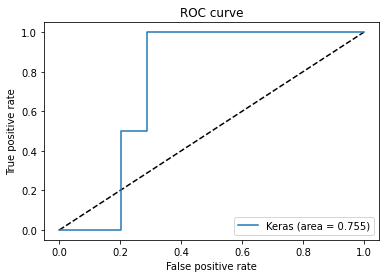

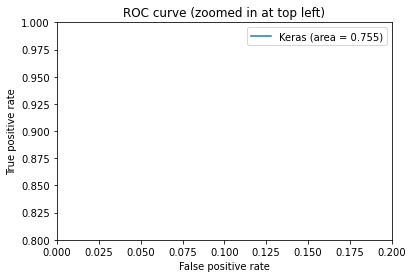

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


### Metric optimization

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

YOUR_THRESHOLD=0.045

over_threshold = pred_Y >= YOUR_THRESHOLD
#print(over_threshold[:10])
over_threshold = [[1] if result[0] else [0] for result in over_threshold]
#print(over_threshold[:10])

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()

sensibility = tp / (tp + fn)
specificity = tn / (tn + fp)

print('Sensibility:', sensibility)
print('Specificity:', specificity)

# I am selecting sensibility since I want to reduce false negatives; however I do not want to lable all as 'positive'
# The threshold 0.045 shows an acceptable threshold between sensibility and specificity

Sensibility: 1.0
Specificity: 0.3939393939393939


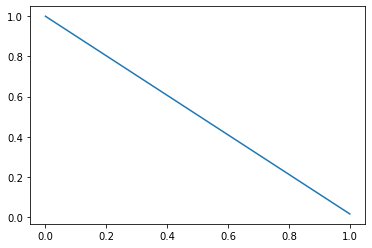

In [24]:
precision, recall, thresholds = precision_recall_curve(valY, over_threshold)
plt.plot(recall, precision)
plt.show()

In [26]:
from sklearn.metrics import f1_score
f1_score(valY, over_threshold, average='macro')

0.2987377279102384

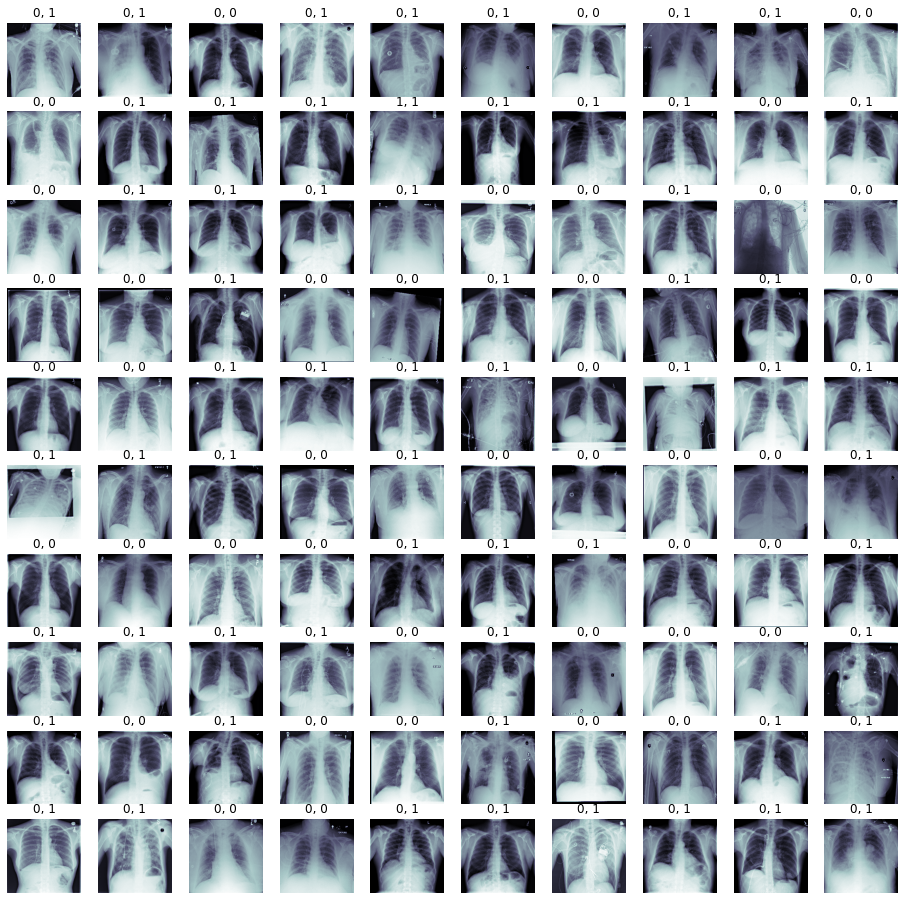

In [27]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    #valY
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [39]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)